# Data Acquisition and Processing Systems (DaPS) (ELEC0136)    
### Final Assignment
---

## Initial imports of packages and settings

In [145]:
# Imports of packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime as dt
import re # regular expression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import snscrape.modules.twitter as sntwitter
import nltk
from pandas_datareader.data import DataReader # For reading stock data from yahoo
import os
import urllib.request
import tarfile
import zipfile
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
import keras.models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

<div class="alert alert-heading alert-info">

#### Task 1: Data Acquisition

You will first have to acquire the necessary data for conducting your study. One essential type of
data that you will need, are the stock prices for each company from April 2017 to April 202 1 as
described in Section 1. Since these companies are public, the data is made available online. The
first task is for you to search and collect this data, finding the best way to access and download
it. A good place to look is on platforms that provide free data relating to the stock market such as
Google Finance or Yahoo! Finance.

[Optional] Providing more than one method to acquire the very same or different data, e.g. from
a downloaded comma-separated-value file and a web API, will result in a higher score.

There are many valuable sources of information for analysing the stock market. In addition to time
series depicting the evolution of stock prices, acquire auxiliary data that is likely to be useful for
the forecast, such as:

- Social Media, e.g., Twitter: This can be used to uncover the public’s sentimental
response to the stock market
- Financial reports: This can help explain what kind of factors are likely to affect the stock
market the most
- News: This can be used to draw links between current affairs and the stock market
- Climate data: Sometimes weather data is directly correlated to some companies’ stock
prices and should therefore be taken into account in financial analysis
- Others: anything that can justifiably support your analysis.

Remember, you are looking for historical data, not live data.
   
    
</div>

## Task 1: Data Acquisition

### 1.1 Acquire AAPL and S&P 500 stock data.

#### 1.1.1 Acquire data from local .csv file.

In [146]:
def acquire_by_local(path):
    """
    Read locally stored CSV file into a pandas DataFrame in the program.
    :param path:
        The CSV file path to read.
    :return data:
        The pandas DataFrame read from a CSV file.
    """
    data = pd.read_csv(path)

    #Set Date as index
    data = data.set_index("Date", drop=True)
    return data

#### 1.1.2 Acquire stock data from pandas_datareader api

In [147]:
def acquire_stock_by_api(stock_name, start_time, end_time):
    """
    Acquire stock data with a specific start date and end date using pandas_datareader API.
    :param stock_name:
        The name of the stock to be acquired.
    :param start_time:
        Start time to a specific data.
    :param end_time:
        End time to a specific day.
    :return stock_data:
        Stock data acquired as a pandas DataFrame.
    """
    stock_data = DataReader(stock_name, 'yahoo', start_time, end_time)
    stock_data.columns = map(str.lower, stock_data.columns)
    return stock_data

#### 1.1.3 Download from Internet and extract

In [148]:
#@title Functions to download data
########################################################################
#
# This file is a partially modified version of one of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2018 by Magnus Erik Hvass Pedersen
#
########################################################################

def download_and_extract(url, download_dir, file_name):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
    :param download_dir:
        Directory where the downloaded file is saved.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    # filename = url.split('/')[-1]
    filename = file_name
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


In [149]:
def acquire_by_url(data_url, data_dir, file_name):
    """
    Acquire data into a pandas DatFrame from a WEB URL.
    :param data_url:
        The wen URL to acquire the data.
    :param data_dir:
        The directory to store the downloaded file into a CSV.
    :param file_name:
        The data file's name.
    :return stock_data:
        stock data DatFrame.
    """
    download_and_extract(url=data_url, download_dir=data_dir, file_name=file_name)

    file_path = os.path.join(data_dir, file_name)
    stock_data = acquire_by_local(file_path)
    return stock_data

### 1.2 Acquire sentiment data of customers based on the tweets they published on the date.

In [150]:
def getTweets():
    """
    Acquire original tweets that Twitter customers published from April 6 2017 until May 31 2021. Save the file into CSV after acquisition and return the DataFrame of it.
    :return df:
        The DataFrame of the tweets.
    """

    # The directory to save the tweets data.
    dir = "datasets/"
    if not os.path.exists(dir):
        os.makedirs(dir)

    # The file name of the original tweets.
    file_name = "Tweets.csv"
    if not os.path.exists(os.path.join(dir,file_name)):
        #As long as the query is valid (not empty or equal to '#')...

        #Creating list to append tweet data
        tweets_list = []

        start = dt.date(2017,4,6)
        start = start.strftime('%Y-%m-%d')

        end = dt.date(2021,6,1)
        end = end.strftime('%Y-%m-%d')
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper('$AAPL' + ' lang:en since:' +  start + ' until:' + end + ' -filter:links -filter:replies').get_items()):

            tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])

        #Creating a dataframe from the tweets list above
        df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

        df.to_csv(dir+file_name)
    else:
        df = pd.read_csv(dir+file_name)
        df = df.drop(columns=['Unnamed: 0'], axis=1)
    return df

In [151]:
def clean(text):
    """
    Clean the text content of each tweet for sentiment analysis.
    :param text:
        Original tweet text content.
    :return text:
        The cleaned tweet text.
    """


    text = re.sub('@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub('#', '', text) # Remove # symbol
    text = re.sub('\$', '', text ) # Remove $ symbol
    text = re.sub('RT[\s]+', '', text) # Remove retweet
    text = re.sub('https?:\/\/\S+', '', text) # Remove hyperlinks
    return  text

In [152]:
def tweets_sentiment_analysis(tweetsdf):
    """
    Preform sentiment analysis to derive a sentiment score for each tweet.
    :param tweetsdf:
        The original tweets DataFrame.
    :return df:
        The tweets DF with sentiment scores.
    """


    df = tweetsdf
    # df = df.set_index('Datetime')

    # Clean the texts
    df['Text'] = df['Text'].apply(clean)

    # Create a new column called "sentiment".
    df['sentiment'] = ''

    for index, row in df.iterrows():
        analyzer = SentimentIntensityAnalyzer().polarity_scores(row['Text'])
        comp = analyzer['compound']
        # print(comp)
        df.loc[index, 'sentiment'] = comp

    save_path = "datasets/Tweets_clean_sentiment.csv"
    if not os.path.exists(save_path):
        df.to_csv(save_path)

    return df

In [153]:
def sentiment_resample_dayAvg(tweets_df_with_sentiment):
    """
    Calculate the mean sentiment score of each day tweets.
    :param tweets_df_with_sentiment:
        Original tweets DF with sentiment scores.
    :return:
        Resampled sentiment DF with day average.
    """
    # Convert the datetime accurate to minutes to days.
    tweets_df_with_sentiment["Datetime"] = pd.to_datetime(tweets_df_with_sentiment["Datetime"]).dt.date

    # Drop the columns in no use
    sentiment_df = tweets_df_with_sentiment[["Datetime","sentiment"]]

    sentiment_df["Datetime"] = pd.to_datetime(sentiment_df["Datetime"])

    sentiment_df = sentiment_df.set_index("Datetime")

    sentiment_dayAvg_df = sentiment_df.resample('D').mean()

    return sentiment_dayAvg_df

In [154]:
def acquire_sentiment_df():
    """
    Wrap up of the processes to acuiqre the sentiment DF.
    :return df:
        Sentiment DF which can be directly used..
    """
    # It needs a couple of hours to use snscrape to acquire tweets
    #  data in getTweets() function. To save time, we read a locally
    #  stored CSV file which is the result after tweets_sentiment_analysis().
    path = "datasets/Tweets_clean_sentiment.csv"
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates=["Datetime"])
    else:
        df = getTweets()
        df = tweets_sentiment_analysis(df)
    df = sentiment_resample_dayAvg(df)
    return df
    # print(df)

### 1.3 Merge the AAPL DF, SP500 DF and sentiment DF.

In [155]:
def acquire_merged_df(AAPL_df, SP500_df, sentiment_df):
    """
    Merge the three DFs of AAPL, SP500 and sentiment to a single DF.
    :param AAPL_df
    :param SP500_df
    :param sentiment_df
    :return: concat:
        DF after the concatenation.
    """
    concat_df = pd.merge(AAPL_df, SP500_df, left_index=True, right_index=True)
    concat_df = pd.merge(concat_df, sentiment_df,how="outer", left_index=True, right_index=True)
    concat_df = concat_df.dropna(axis=0, how='any')
    concat_df.columns = map(str.lower, concat_df.columns)
    concat_df.index.name = "date"
    return concat_df



<div class="alert alert-heading alert-info">
    
## Task 2: Data Storage

Once you have found a way to acquire the relevant data, you need to decide on how to store it.
You should choose a format that allows an efficient read access to allow training a parametric
model. Also, the data corpus should be such that it can be easily inspected. Data can be stored
locally, on your computer.
    
</div>

In [156]:
def store(df, file_name, dir="datasets/"):
    """
    Store the acquired data as the form of DataFrame into a local csv file.
    :param df:
        Acquired data.
    :param dir:
        Directory to save.
    :param file_name:
        File name of the saved data file.
    """

    path = os.path.join(dir,file_name)
    if not os.path.exists(path):
        df.to_csv(path)
        print("The data file is successfully saved in ", str(path))
        return
    print("The data file is already saved in ", str(path))
    return

<div class="alert alert-heading alert-warning">

[Optional] Create a simple API to allow Al retrieving the compound of data you collected. It is enough to provide a single access point to retrieve all the data, and not implement query mechanism. The API must be accessible from the web. If you engage in this task data must be stored online.  
    
</div>

In [157]:
def retrieve(data_URL):
    """
    Retrieve the data stored in APEX database.
    :param data_URL: The URL created by APEX's RESTful service to retrieve the data.
    :return: df:
        The data acquired from APEX.
    """
    response = requests.request("GET", data_URL)
    # print(response.text)

    #Results contain the required data
    df = pd.json_normalize(response.json()['items'])

    df = df.drop("id", axis=1)
    df = df.rename(columns={"date_": "date"})

    df["date"]= pd.to_datetime(df["date"])
    df['date'] = df["date"].dt.strftime('%Y-%m-%d')

    df["date"]= pd.to_datetime(df["date"])
    df = df.set_index("date", drop=True)
    df = df.sort_index()
    # df.info()
    return df

<div class="alert alert-heading alert-info">

## Task 3: Data Preprocessing

Now that you have the data stored, you can start preprocessing it. Think about what features to
keep, which ones to transform, combine or discard. Make sure your data is clean and consistent
(e.g., are there many outliers? any missing values?). You are expected to:

1. Clean the data from missing values and outliers, if any.
2. Provide useful visualisation of the data. Plots should be saved on disk, and not printed on
the juptyer notebook.
3. Transform your data (e.g., using normalization, dimensionality reduction, etc.) to improve
the forecasting performance.

</div>

### 3.1 Visualization

In [158]:
def visualize(df, fileName, attrs, ylabel):
    """
    Plot and save the figure showing the attribute values movement in a DF, with x being date, y being value.
    :param df:
        dataframe to plot.
    :param fileName:
        File name to save.
    :param attrs:
        list of attributes' names of the input DF.
    :param ylabel:
        ylabel text of the figure.
    """
    date_x = df.index

    plt.figure(figsize=(16,7))

    plt.xlabel('Date')
    plt.ylabel(ylabel)

    for attr in attrs:
        plt.plot_date(date_x, df[attr], '-', linewidth=0.3, label=attr)
    plt.grid(1)
    plt.tight_layout()

    plt.legend()


    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, fileName)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return


### 3.2 Outlier--Calculation and plot of z-scores.

In [159]:
def calculate_plot_outlier_z_score(df, file_name):
    """
    Calculate and plot z-scores of attributes in a DF.
    :param df:
        DF as input.
    :param file_name:
        File name to save.
    """

    columns = df.columns
    z_scores = []
    for attr in columns:
        z = np.abs(stats.zscore(df[attr]))
        z_scores.append(z)

    plt.figure(figsize=(16,7))
    date_x = df.index
    plt.xlabel('Date')
    plt.ylabel('Z score')
    plt.grid(1)
    index = 0
    for z_score in z_scores:
        plt.plot_date(date_x, z_score, '-',linewidth=0.3, label=columns[index])
        index += 1
    plt.legend()
    plt.tight_layout()

    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return

### 3.3 Transformation with normalization and PCA

In [160]:
def Data_Standard(input):
    """
    Normalize the input data.
    :param input:
    :return input_std:
        normalized data.
    """
    std_scaler = StandardScaler()
    input_std = std_scaler.fit_transform(input)
    return input_std

In [161]:
def PCA_Transform(input, flag_specify_n_comp, n_components=None):
    """
    PCA transform of the input data.
    :param input
    :param flag_specify_n_comp:
        If True, we specify a number of dimensions after dimension reduction.
    :param n_components:
        When flag_specify_n_comp set to False, it is None.
    :return output:
        Data after PCA.
    :return exp_var_ratio:
        Explained variance ratio of each component after PCA.

    """
    if flag_specify_n_comp:
        pca = PCA(n_components=n_components)
    else:
        pca = PCA()
    output = pca.fit_transform(input)
    exp_var_ratio = pca.explained_variance_ratio_
    # print("explained variance ratio:",exp_var_ratio)
    return output, exp_var_ratio

In [162]:
def plot_explain_variance_ratio(exp_var_pca, file_name):
    """
    Plot the explained variance ratio of data after PCA.
    :param exp_var_pca:
        Explained variance ratio of the data after PCA.
    :param file_name:
        File name to save.
    """
    # Cumulative sum of eigenvalues; This will be used to create step plot
    # for visualizing the variance explained by each principal component.
    #
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    #
    # Create the visualization plot
    #
    plt.figure(figsize=(16,9))

    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()

    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return


In [163]:
def plot_PCA(df, file_name):
    """
    Wtapper function to plot the explained variance ratios.
    :param df:
        DataFrame to be transformed.
    :param file_name:
        File name to save.
    """
    X = df.values
    X_std = Data_Standard(X)
    X_pca, exp_var_ratio = PCA_Transform(X_std, flag_specify_n_comp=False)
    plot_explain_variance_ratio(exp_var_ratio,file_name)

<div class="alert alert-heading alert-info">
    
## Task 4: Data Exploration

After ensuring that the data is well preprocessed, it is time to start exploring the data to carry out
hypotheses and intuition about possible patterns that might be inferred. Depending on the data,
different EDA (exploratory data analysis) techniques can be applied, and a large amount of
information can be extracted.
For example, you could do the following analysis:

    
- Time series data is normally a combination of several components:
  - Trend represents the overall tendency of the data to increase or decrease over time.
  - Seasonality is related to the presence of recurrent patterns that appear after regular
intervals (like seasons).
  - Random noise is often hard to explain and represents all those changes in the data
that seem unexpected. Sometimes sudden changes are related to fixed or predictable
events (i.e., public holidays).
- Features correlation provides additional insight into the data structure. Scatter plots and
boxplots are useful tools to spot relevant information.
- Explain unusual behaviour.
- Explore the correlation between stock price data and other external data that you can
collect (as listed in Sec 2.1)
- Use hypothesis testing to better understand the composition of your dataset and its
representativeness.

    
At the end of this step, provide key insights on the data. This data exploration procedure should
inform the subsequent data analysis/inference procedure, allowing one to establish a predictive
relationship between variables.

</div>

### 4.1 EDA

#### 4.1.1 Trends, seasonality and noise.

In [164]:
def plot_trend_seasonality_noise(df, attr_name, file_name):
    """
    Plot the trend, seasonality and noise of an attribute in a DF.
    :param df:
        Data frame.
    :param attr_name:
        Name of the attribute.
    :param file_name:
        File name to save.
    """
    plt.rcParams['figure.figsize'] = 11,9
    plt.rcParams['lines.linewidth']=0.5
    plt.rcParams['lines.markersize']=1
    decomposed = sm.tsa.seasonal_decompose(df[attr_name], period=250)
    figure = decomposed.plot()

    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return

#### 4.1.2 Scatter Plot

In [165]:
def plot_scatter(df, attr_1, attr_2, file_name):
    """
    Generate scatter plot of two attributes in a Data Frame.
    :param df:
        Data frame.
    :param attr_1:
        First attribute.
    :param attr_2:
        Second attribute.
    :param file_name:
        File name to save.
    """
    plt.figure()
    x = df[attr_1]
    y = df[attr_2]
    plt.scatter(x,y, linewidth=1)
    plt.xlabel(attr_1)
    plt.ylabel(attr_2)
    plt.tight_layout()

    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return

#### 4.1.3 Correlation Heatmap

In [166]:
def plot_cor_heatmap(df, file_name):
    """
    Plot a covariance heatmap of attributes in a Data frame.
    :param df:
        Data frame.
    :param file_name:
        File name to save.
    """


    plt.figure(figsize=(30,30))
    correlation_heatmap = sns.heatmap(df.corr(),linewidths=0.5)
    figure = correlation_heatmap.get_figure()

    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        figure.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return

#### 4.1.4 Pearson's Correlation and Spearman's Correlation

In [167]:
def cal_pearsonr(df, attr1, attr2):
    """
    Calculate Peason's correlation value between two attributes in a DF.
    :param df:
        Data frame.
    :param attr1:
        Attribute 1 in DF.
    :param attr2:
        Attribuet 2 in DF.
    :return:
        Pearson's correlation value between attr 1 and attr 2.
    """
    corr, _ = pearsonr(df[attr1],df[attr2])
    print("Pearson's correlation of {} and {}".format(attr1,attr2), corr)
    return corr

In [168]:
def cal_spearmanr(df, attr1, attr2):
    """"
    Calculate Spearman's correlation value between two attributes in a DF.
    :param df:
        Data frame.
    :param attr1:
        Attribute 1 in DF.
    :param attr2:
        Attribuet 2 in DF.
    :return:
        Spearman's correlation value between attr 1 and attr 2.
    """
    corr, _ = spearmanr(df[attr1],df[attr2])
    print("Spearman's correlation between {} and {}".format(attr1,attr2), corr)
    return corr

### 4.2 Chi-Square Hypothesis Test

In [169]:
def count_stock_change(df, attr1, attr2):
    """
    Count the binary values and generate Cali table for the two attrbutes in a DF.
    :param df:
        Data frame.
    :param attr1:
        Attribute 1 in DF.
    :param attr2:
        Attribuet 2 in DF.
    :return Table_Simple:
        Cali table without total counting.
    :return Table_with_Total:
        Cali table with total counting.
    """

    attr1_list = df[attr1].values
    attr2_list = df[attr2].values

    attr1Up_attr2Up = 0
    attr1Up_attr2Down = 0
    attr1Down_attr2Up = 0
    attr1Down_attr2Down = 0
    for i in range(len(attr1_list)):
        if attr1_list[i] == 1:
            if attr2_list[i] == 1:
                attr1Up_attr2Up += 1
            else:
                attr1Up_attr2Down += 1
        else:
            if attr2_list[i] == 1:
                attr1Down_attr2Up += 1
            else:
                attr1Down_attr2Down += 1
    attr1Up_cnt = len(attr1_list[attr1_list == 1])
    attr1Down_cnt = len(attr1_list[attr1_list == 0])
    attr2Up_cnt = len(attr2_list[attr2_list == 1])
    attr2Down_cnt = len(attr2_list[attr2_list == 0])
    total_cnt = len(attr1_list)

    attr_up = [attr1Up_attr2Up, attr1Down_attr2Up]
    attr_down = [attr1Up_attr2Down, attr1Down_attr2Down]

    index = ['{} Up'.format(attr1), '{} Down'.format(attr1)]
    d = {attr2 + ' Up':attr_up, attr2 + ' Down':attr_down}
    Table_Simple = pd.DataFrame(data=d, index=index, columns=None)


    attr_up = [attr1Up_attr2Up, attr1Down_attr2Up, attr2Up_cnt]
    attr_down = [attr1Up_attr2Down, attr1Down_attr2Down, attr2Down_cnt]
    total = [attr1Up_cnt, attr1Down_cnt, total_cnt]

    index = ['{} Up'.format(attr1), '{} Down'.format(attr1), 'Total']
    d = {attr2 + ' Up':attr_up, attr2 + ' Down':attr_down, 'Total':total}
    Table_with_Total = pd.DataFrame(data=d, index=index, columns=None)

    return (Table_Simple, Table_with_Total)



In [170]:
def Do_Chi_Square(df, attr1, attr2):
    """
    Do the Chi-Squared Test for two attribues in a dataframe.
    :param df:
        Data frame.
    :param attr1:
        Name of attribute 1.
    :param attr2:
        Name of attribuet 2.
    :return:
    """
    print("--------------------------------------------")
    print("Do Chi-Square test between {} and {}".format(attr1, attr2))
    table_simple, table_with_total = count_stock_change(df, attr1, attr2)
    print(table_with_total)
    stat, p, dof, expected = chi2_contingency(table_simple)
    print("statistic", stat)
    print("p-value", p)
    print("degress of freedom: ",dof)
    print("table of expected frequencies\n",expected)

    prob = 0.99
    critical = chi2.ppf(prob, dof)
    if abs(stat) >= critical:
        print('Dependent (reject H0) with {} probability'.format(str(prob)))
    else:
        print('Independent (fail to reject H0)')
    print("--------------------------------------------")




<div class="alert alert-heading alert-info">

## Task 5: Inference

Train a model to predict the closing stock price on each day for the data you have already
collected, stored, preprocessed and explored from previous steps. The data must be spanning
from April 2017 to April 202 1.
You should develop two separate models:


1. A model for predicting the closing stock price on each day for a 1-month time window (until
    end of May 202 1 ), using only time series of stock prices.
2. A model for predicting the closing stock price on each day for a 1-month time window (until
    end of May 202 1 ), using the time series of stock prices and the auxiliary data you collected.
Which model is performing better? How do you measure performance and why? How could you
further improve the performance? Are the models capable of predicting the closing stock prices
far into the future?

[IMPORTANT NOTE] For these tasks, you are not expected to compare model architectures, but
examine and analyse the differences when training the same model with multiple data attributes
and information from sources. Therefore, you should decide a single model suitable for time series
data to solve the tasks described above. Please see the lecture slides for tips on model selection
and feel free to experiment before selecting one.

The following would help you evaluate your approach and highlight potential weaknesses in your
process:

1. Evaluate the performance of your model using different metrics, e.g. mean squared error,
    mean absolute error or R-squared.
2. Use ARIMA and Facebook Prophet to explore the uncertainty on your model’s predicted
    values by employing confidence bands.
3. Result visualization: create joint plots showing marginal distributions to understand the
    correlation between actual and predicted values.
4. Finding the mean, median and skewness of the residual distribution might provide
    additional insight into the predictive capability of the model.
</div>

In [171]:
def load_data(train_set, label, num_dimensions, input_window_size=250, output_window_size=20):
    """
    Generate the x_train, y_train and x_test in prediction using LSTM model.
    :param train_set:
        x_train data original inputs.
    :param label:
        y_train data original inputs.
    :param num_dimensions:
        Input data number of dimensions.
    :param input_window_size:
        For example, when this is set to 250, we use the past data of 250 days to forecast future.
    :param output_window_size:
        The number of data to forecast the future.
    :return x_train, y_train, x_test
    """

    train_set_len = len(train_set)

    x_train = []
    y_train = []

    for i in range(input_window_size, train_set_len-output_window_size + 1):
        x_train.append(train_set[i - input_window_size:i, :])
        y_train.append(label[i:i + output_window_size])

    x_train = np.array(x_train, dtype=float)
    y_train = np.array(y_train, dtype=float)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_dimensions))

    x_test = []
    x_test.append(train_set[train_set_len-input_window_size: , :])
    x_test = np.array(x_test, dtype=float)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_dimensions))
    return x_train, y_train, x_test




In [172]:
#LSTM model without auxiliary data as input
def train_LSTM_without_Aux(x_train, y_train):
    """
    Train an LSTM model with input dataset dimension (250, 2).
    :param x_train
    :param y_train
    :return model:
        Trained model.
    """
    download_dir="models/"
    file_name = "LSTMWithoutAux"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        num_attr = 2 # Two dimensions for input data
        output_size = 20 # Output 20 data points
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], num_attr)))
        model.add(LSTM(64,return_sequences=False))
        model.add(Dense(64))
        model.add(Dense(output_size))

        model.compile(optimizer="adam", loss="mean_squared_error", metrics="mape")
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
        model.fit(x_train, y_train, batch_size=32, epochs=300, callbacks=[callback])

        # Save the trained model

        model.save(path)
        print("The model is saved with ", str(path))
        return model
    else:
        print("The model is already saved as ", str(path))
        model = keras.models.load_model(path)

        return model

In [173]:
#LSTM model with auxiliary data as input
def train_LSTM_with_Aux(x_train, y_train):
    """
    Train an LSTM model with input dataset dimension (250, 5).
    :param x_train
    :param y_train
    :return model:
        Trained model.
    """
    download_dir="models/"
    file_name = "LSTMWithAux"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        num_attr = 5 # Two dimensions for input data
        output_size = 20 # Output 20 data points
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], num_attr)))
        model.add(LSTM(64,return_sequences=False))
        model.add(Dense(64))
        model.add(Dense(output_size))

        model.compile(optimizer="adam", loss="mean_squared_error", metrics="mape")
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
        model.fit(x_train, y_train, batch_size=32, epochs=300,callbacks=[callback])

        # Save the trained model

        model.save(path)
        print("The model is saved with ", str(path))
        return model
    else:
        print("The model is already saved as ", str(path))
        model = keras.models.load_model(path)

        return model

In [174]:
def get_model_predictions(model, x_train, x_test, input_dimension, y_train_mean, y_train_std):
    """
    Get the predicted close prices in the training and testing processes of the model.
    :param model:
    :param x_train:
        x_train when training the model.
    :param x_test:
        x_test generated to test the model.
    :param input_dimension:
        Dimensions of input x.
    :param y_train_mean:
        Mean value of y_train.
    :param y_train_std:
        Standard deviation of y_train.
    :return train_predictions:
        predicted prices in training.
    :return test_predictions:
        predicted prices in testing.
    :return predictions_total:
        Reverse normalization and concatenation of train_predictions and test_predictions.
    """
    train_predictions = []
    # Start appending the predicted prices in training process
    for item in x_train:
        item = np.reshape(item, (1, 250, input_dimension))
        predicted_close_price = model.predict(item)
        train_predictions.append(predicted_close_price[0, 0])

    # Append last 20 predicted close prices in the training process.
    train_predictions = train_predictions[:-1]
    predicted_close_price = model.predict(x_train[-1].reshape(1, 250, input_dimension))
    for i in range(len(predicted_close_price[0])):
        train_predictions.append(predicted_close_price[0, i])

    #------------------------------------------------------
    test_predictions = model.predict(x_test)
    test_predictions = test_predictions.reshape(-1)

    # Concat the train predictions and test predictions
    predictions_total = [*train_predictions,  *test_predictions]

    # Reverse normalization
    predictions_total = (np.array(predictions_total) * y_train_std) + y_train_mean

    return train_predictions, test_predictions, predictions_total


In [175]:
def plot_model_prediction(predictions_total, AAPL_df, AAPL_df_test, AAPL_df_total, file_name):
    """
    Plot the predicted prices compared to real ones.
    :param predictions_total:
        Predicted values after inverse normalization.
    :param AAPL_df:
        AAPL's train DF from 2017-04-06 to 2021-04-30
    :param AAPL_df_test:
        AAPL's test DF from 2021-05-01 to 2021-05-31
    :param AAPL_df_total:
        Concat of AAPL_df and AAPL_df_test
    :param file_name:
        File name to save.
    :return:
    """
    plt.figure(figsize=(16,7))
    plt.ylim((30,170))

    # Real prices
    plt_y_1 = AAPL_df['close'].values.tolist()+AAPL_df_test['close'].values.tolist()

    # Real prices of first 250 days + predicted prices.
    plt_y_2 = AAPL_df.loc[:'2018-04-04']['close'].tolist()  + predictions_total.tolist()

    plt.plot_date(AAPL_df_total.index, plt_y_2,'-', color='red', label='Predicted AAPL price',linewidth=0.3)
    plt.plot_date(AAPL_df_total.index, plt_y_1,'-', color = 'blue', label = 'AAPL real price',linewidth=0.3)
    plt.axvline(dt.datetime(2021, 4, 30), linewidth=0.2, color = 'purple')
    plt.title('AAPL Stock Close Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AAPL Close Price')
    plt.legend()
    plt.tight_layout()


    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return


In [176]:
def create_joint_plot(forecast, file_name, limit_min, limit_max, x='yhat', y='y', title=None):
    """
    Plot joint plot.
    :param forecast:
        Preditions values.
    :param file_name:
        File name to save.
    :param limit_min:
        Scale of the figure.
    :param limit_max:
        Scale of the figure
    :param x:
        predicted values' column in DF named 'yhat'
    :param y:
        Real values' column in DF named 'y'
    :param title:
        The plot's title.
    """

    g = sns.jointplot(x='yhat', y='y', data=forecast, kind="reg", color="b")
    g.fig.set_figwidth(12)
    g.fig.set_figheight(12)


    ax = g.fig.axes[1]
    if title is not None:
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]
    ax.text(limit_min+10, limit_max-10, "R = {:+4.2f}".format(forecast.loc[:,['y','yhat']].corr().iloc[0,1]), fontsize=16)
    ax.set_xlabel('Predictions', fontsize=15)
    ax.set_ylabel('Observations', fontsize=15)
    ax.set_xlim(limit_min, limit_max)
    ax.set_ylim(limit_min,limit_max)
    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    plt.tight_layout()

    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return


In [177]:
def plot_residual(df_residual, file_name, title=None):
    """
    Plot residual distribution figure.
    :param df_residual:
        DF contains real values and predicted values.
    :param file_name:
        File name to save.
    :param title:
        Title of the figure.
    """

    f, ax = plt.subplots(figsize=(16, 16))

    sns.distplot(df_residual, ax=ax, color='0.7')
    ax.grid(ls=':')
    ax.set_xlabel('Residuals', fontsize=15)
    ax.set_ylabel("Relative frequency", fontsize=15)
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

    from scipy.stats import skew
    ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:4.2f}". \
            format(skew(df_residual), np.median(df_residual), df_residual.mean()), \
            fontsize=14, transform=ax.transAxes)

    ax.axvline(0, color='0.4')

    ax.set_title(title, fontsize=17)
    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    plt.tight_layout()
    plt.savefig(path)

## Some other util functions.

In [178]:
def create_dirs():
    """
    Create datasets/ and images/ and models/ directories if they are not already existed.
    """
    if not os.path.exists("datasets/"):
        os.makedirs("datasets/")
    if not os.path.exists("images/"):
        os.makedirs("images/")
    if not os.path.exists("models/"):
        os.makedirs("models/")

<div class="alert alert-heading alert-danger">

## Autorun

</div>

In [179]:
def main():
    """This function will be called to check that your work is reproducible, and it is the only function that will be called by us.
    It should perform all the work that you used to support your Report, e.g. storing data, running experiments, saving figures.
    
    Example:
    ```
    data = acquire()
    store(data)
    data = process(data)
    explore(data)
    model = create_model()
    trained_model = train(model, data)
    performance = evaluate(trained_model, data)
    ```
    """
    # Settings
    sns.set_style('whitegrid')
    plt.style.use("fivethirtyeight")
    nltk.download('vader_lexicon')  # Download dict for sentiment analysis

    create_dirs()
    pd.options.mode.chained_assignment = None  # default='warn'

    # Some variables
    dataset_dir = "datasets/"
    img_dir = "images/"
    model_dir = "models/"
    #--------------------------------------------------------------------
    # 1. Data Acquisition
    print("----------------------------------------------------------------\n")
    print("1.Data Acquisition:\n")
    # Acquire AAPL data with API
    start = datetime(2017, 4, 6)
    end = datetime(2021, 4, 30)
    AAPL_df = acquire_stock_by_api("AAPL",start, end)
    AAPL_df_test = acquire_stock_by_api("AAPL", datetime(2021,5,1), datetime(2021,5,31))
    AAPL_df_total = acquire_stock_by_api("AAPL", datetime(2017,4,6), datetime(2021,5,31))
    print("AAPL stock data is acquired: ")
    print(AAPL_df.head())
    print("\n")

    # Acquire S&P 500 data with API
    SP500_df = acquire_stock_by_api("SPY",start, end)
    print("S&P 500 stock data is acquired: ")
    print(SP500_df.head())
    print("\n")

    # Rename the columns of SP500_df to avoid the same names with AAPL.
    SP500_df = SP500_df.rename(columns={"high":"high_sp", "low":"low_sp", "open":"open_sp","close":"close_sp","volume":"volume_sp", "adj close":"adj close_sp"})

    """
    # Note: Besides acquisition of stock data from API, it is available to
    #acquire by web URL. The two methods of using API and web URL are approximately
    #the same. So we don't run the method of acquirng by URL. But we know the way to do it:

    AAPL_URL = "https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1491436800&period2=1619827200&interval=1d&events=history&includeAdjustedClose=true"
    SP500_URL = "https://query1.finance.yahoo.com/v7/finance/download/SPY?period1=1491436800&period2=1619827200&interval=1d&events=history&includeAdjustedClose=true"

    AAPL_df = acquire_by_url(AAPL_URL, dataset_dir, "AAPL.csv")
    SP500_df = acquire_by_url(SP500_URL, dataset_dir, "SP500.csv")

    """

    # Acquire sentiment data
    sentiment_df = acquire_sentiment_df()
    print("Sentiment data is acquired: ")
    print(sentiment_df.head())
    print("\n")

    # Merge the three data sources into a single dataframe.
    concat_df = acquire_merged_df(AAPL_df, SP500_df,sentiment_df)
    print("The three datasets are merged to a single dataframe: ")
    print(concat_df.head())
    print("\n")

    #--------------------------------------------------------------------
    # 2. Data Storage
    print("----------------------------------------------------------------\n")
    print("2.Data Storage:\n")

    # Store the acquired AAPL_df, SP500_df, sentiment_df and concat_df into the local CSV files.
    store(AAPL_df, "AAPL.csv")
    store(SP500_df, "SP500.csv")
    store(sentiment_df, "sentiment.csv")
    store(concat_df, "concat.csv")

    # The dataset after concatenation is also stored online within APEX,
    #   a cloud-based SQL relational database.
    #   By creating the RESTful service, we can easily
    #   access and retrieve the stored data by a URL link.
    concat_data_APEX_URL = "https://apex.oracle.com/pls/apex/20057524/daps/concat"
    tmp_concat_df = retrieve(concat_data_APEX_URL)
    print("\n")
    print("Concat data of AAPL, SP500 and sentiment is successfully retrieved from APEX online: ")
    print(tmp_concat_df.head())

    """
    # Some other URLs created by RESTful service of APEX
        #to retrieve the three datasets respectively
    AAPL_data_APEX_URL = "https://apex.oracle.com/pls/apex/20057524/daps/aapl"
    SP500_data_APEX_URL = "https://apex.oracle.com/pls/apex/20057524/daps/sp500"
    sentiment_data_APEX_URL = "https://apex.oracle.com/pls/apex/20057524/daps/sentiment"
    """


    #--------------------------------------------------------------------
    # 3. Data Preprocessing
    print("----------------------------------------------------------------\n")
    print("3.Data Preprocessing:\n")

    # (1) Data visualization

    # Plot the prices of AAPL
    visualize(AAPL_df, 'Visualize_AAPL_Prices.pdf', ['open', 'high', 'low', 'close', 'adj close'],ylabel="Price")
    # Plot the volume of AAPL
    visualize(AAPL_df,"VisualAAPLVol.pdf",['volume'],ylabel="Volume")
    # Plot the prices of SP500
    visualize(concat_df, "Visualize_SP_Prices.pdf",['open_sp', 'high_sp', 'low_sp', 'close_sp', 'adj close_sp'], "Price")
    # Plot the volume of SP500
    visualize(concat_df,'VisualSPVol.pdf',['volume_sp'], ylabel="Volume")
    # Plot the close percentage change of AAPL
    tmp_AAPL_df = AAPL_df.copy(deep=True)
    tmp_AAPL_df['pct change'] = tmp_AAPL_df.close.div(tmp_AAPL_df.close.shift())
    visualize(tmp_AAPL_df, "Visualize_AAPL_PctChange.pdf",['pct change'],"Percentage Change")
    # Plot the sentiment
    visualize(concat_df, "VisualSentiment.pdf", ["sentiment"], "Sentiment Score")


    # (2) Outlier part--Calculate and Plot the Z-scores.
    calculate_plot_outlier_z_score(AAPL_df, "AAPLZscore.pdf")
    calculate_plot_outlier_z_score(SP500_df, "SP500ZScore.pdf")

    # (3) Transformation with data normalization and PCA.
    plot_PCA(AAPL_df, "AAPLPCA.pdf")
    plot_PCA(concat_df, "ConcatPCA.pdf")

    # 4. Data Exploration
    print("----------------------------------------------------------------\n")
    print("4.Data Exploration:\n")

    # (1) EDA

    # Plot trends, seasonality, and noise.
    # AAPL close price
    plot_trend_seasonality_noise(concat_df, "close", "AAPLCloseSeason.pdf")
    # S&P 500 close price
    plot_trend_seasonality_noise(concat_df, "close_sp", "SPCloseSeason.pdf")
    # Sentiment
    plot_trend_seasonality_noise(concat_df, "sentiment", "SentimentSeason.pdf")


    # Scatter plots.
    tmp_concat_df = concat_df.copy(deep=True)
    tmp_concat_df['volume_pct_change'] = tmp_concat_df.volume.div(tmp_concat_df.volume.shift())
    tmp_concat_df['close_pct_change'] = tmp_concat_df.close.div(tmp_concat_df.close.shift())

    plot_scatter(tmp_concat_df, "close","close_sp","ScatterAAPLClose-SPClose.pdf")
    plot_scatter(tmp_concat_df,"close_pct_change","sentiment","ScatterCloseSentiment.pdf")

    # Covariance heatmap.
    plot_cor_heatmap(tmp_concat_df, "heatmap.pdf")

    # Calculate Pearson's and Spearman's correlation values betwee attributes.
    cal_pearsonr(tmp_concat_df, "close", "close_sp")
    cal_pearsonr(tmp_concat_df, "open", "open_sp")
    cal_pearsonr(tmp_concat_df, "high", "high_sp")
    cal_pearsonr(tmp_concat_df, "low", "low_sp")
    cal_pearsonr(tmp_concat_df, "adj close", "adj close_sp")
    cal_pearsonr(tmp_concat_df.dropna(axis=0, how='any'), "close_pct_change","sentiment")
    cal_pearsonr(tmp_concat_df, "volume","volume_sp")

    cal_spearmanr(tmp_concat_df, "close", "close_sp")
    cal_spearmanr(tmp_concat_df, "open", "open_sp")
    cal_spearmanr(tmp_concat_df, "high", "high_sp")
    cal_spearmanr(tmp_concat_df, "low", "low_sp")
    cal_spearmanr(tmp_concat_df, "adj close", "adj close_sp")
    cal_spearmanr(tmp_concat_df.dropna(axis=0, how='any'), "close_pct_change","sentiment")
    cal_spearmanr(tmp_concat_df, "volume", "volume_sp")

    #(2) Hypothesis Testing with Chi-Square test.
    # Transform the attributes in DF to binary values.
    # If an attribute's value of this is bigger than the last day, set
    # the value 1, otherwise 0.
    tmp_concat_df['sentiment_change'] = tmp_concat_df['sentiment'].sub(tmp_concat_df['sentiment'].shift())
    tmp_concat_df.sentiment_change[tmp_concat_df.sentiment_change > 0] = 1
    tmp_concat_df.sentiment_change[tmp_concat_df.sentiment_change <= 0] = 0

    tmp_concat_df['volume_change_sp'] = tmp_concat_df['volume_sp'].sub(tmp_concat_df['volume_sp'].shift())
    tmp_concat_df.volume_change_sp[tmp_concat_df.volume_change_sp > 0] = 1
    tmp_concat_df.volume_change_sp[tmp_concat_df.volume_change_sp <= 0] = 0

    tmp_concat_df['close_change'] = tmp_concat_df['close'].sub(tmp_concat_df['close'].shift())
    tmp_concat_df.close_change[tmp_concat_df.close_change > 0] = 1
    tmp_concat_df.close_change[tmp_concat_df.close_change <= 0] = 0

    tmp_concat_df['volume_change'] = tmp_concat_df['volume'].sub(tmp_concat_df['volume'].shift())
    tmp_concat_df.volume_change[tmp_concat_df.volume_change > 0] = 1
    tmp_concat_df.volume_change[tmp_concat_df.volume_change <= 0] = 0


    tmp_concat_df['close_change_sp'] = tmp_concat_df['close_sp'].sub(tmp_concat_df['close_sp'].shift())
    tmp_concat_df.close_change_sp[tmp_concat_df.close_change_sp > 0] = 1
    tmp_concat_df.close_change_sp[tmp_concat_df.close_change_sp <= 0] = 0

    tmp_concat_df = tmp_concat_df.dropna(axis=0, how='any')

    Do_Chi_Square(tmp_concat_df, "close_change", "volume_change")
    Do_Chi_Square(tmp_concat_df, "close_change", "close_change_sp" )
    Do_Chi_Square(tmp_concat_df, "close_change", "volume_change_sp" )
    Do_Chi_Square(tmp_concat_df, "close_change", "sentiment_change" )

    # 5. Data Inference
    print("----------------------------------------------------------------\n")
    print("5.Data Inference:\n")

    # Acquire the mean and standard of y_train, which is the close
    # prices of AAPL.
    y_train_mean = np.mean(AAPL_df["close"])
    y_train_std = np.std(AAPL_df["close"])
    # y_train needs to be normalized as label in training the model.
    y_train_normal = (AAPL_df["close"] - y_train_mean)/y_train_std
    y_test = AAPL_df_test["close"].values

    #(1) model without auxiliary data
    X = AAPL_df.values
    X_std = Data_Standard(X)
    X_pca, _ = PCA_Transform(X_std, flag_specify_n_comp=True, n_components=2)

    x_train,y_train, x_test = load_data(train_set=X_pca, label=y_train_normal, num_dimensions=2)
    model_without_Aux = train_LSTM_without_Aux(x_train, y_train)

    train_predictions, test_predictions, totla_predictions = get_model_predictions(model_without_Aux, x_train, x_test, 2, y_train_mean, y_train_std)

    print("Predictions of AAPL prices in May without auxiliary data: \n")
    print(((test_predictions * y_train_std) + y_train_mean))

    plot_model_prediction(totla_predictions, AAPL_df, AAPL_df_test,AAPL_df_total, "PredictWithoutAux.pdf")

    MSE = mean_squared_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean))
    RMSE = mean_squared_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean), squared=False)
    MAE = mean_absolute_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean))
    MAPE = mean_absolute_percentage_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean))

    print("MSE in task without auxiliary data: ", MSE)
    print("RMSE in task without auxiliary data: ", RMSE)
    print("MAE in task without auxiliary data: ", MAE)
    print("MAPE in task without auxiliary data: ", MAPE)



    # Plot joint plots.
    d = {'yhat':((test_predictions * y_train_std) + y_train_mean), 'y':AAPL_df_test['close'].values}

    df_for_joint_plot_without_Aux_test = pd.DataFrame(data=d, dtype=float)
    create_joint_plot(df_for_joint_plot_without_Aux_test, title='Test set', file_name="JointPlotWithoutAuxTest.pdf", limit_min=120, limit_max=150)

    # Plot residual distribution
    df_yhat = (test_predictions * y_train_std) + y_train_mean
    df_y = AAPL_df_test['close'].values

    df_residual = df_yhat-df_y
    plot_residual(df_residual, "ResidualPlotWithoutAuxTest.pdf", title="Residual Distribution test set")

    #------------------------------------------------------------
    #(2) model with auxiliary data
    X = concat_df.values
    X_std = Data_Standard(X)
    X_pca, _ = PCA_Transform(X_std,flag_specify_n_comp=True, n_components=5)

    x_train,y_train, x_test = load_data(train_set=X_pca, label=y_train_normal, num_dimensions=5)

    model_with_Aux = train_LSTM_with_Aux(x_train, y_train)

    train_predictions, test_predictions, totla_predictions = get_model_predictions(model_with_Aux, x_train, x_test, 5, y_train_mean, y_train_std)


    print("Predictions of AAPL prices in May with auxiliary data: \n")
    print(((test_predictions * y_train_std) + y_train_mean))

    plot_model_prediction(totla_predictions, AAPL_df, AAPL_df_test,AAPL_df_total, "PredictWithAux.pdf")

    MSE = mean_squared_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean))
    RMSE = mean_squared_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean), squared=False)
    MAE = mean_absolute_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean))
    MAPE = mean_absolute_percentage_error(AAPL_df_test['close'].values, ((test_predictions * y_train_std) + y_train_mean))
    print("MSE in task with auxiliary data: ", MSE)
    print("RMSE in task with auxiliary data: ", RMSE)
    print("MAE in task with auxiliary data: ", MAE)
    print("MAPE in task with auxiliary data: ", MAPE)

    # Plot joint plots.
    d = {'yhat':((test_predictions * y_train_std) + y_train_mean), 'y':AAPL_df_test['close'].values}

    df_for_joint_plot_with_Aux_test = pd.DataFrame(data=d, dtype=float)
    create_joint_plot(df_for_joint_plot_with_Aux_test, title='Test set', file_name="JointPlotWithAuxTest.pdf", limit_min=120, limit_max=150)

    # Plot residual distribution
    df_yhat = (test_predictions * y_train_std) + y_train_mean
    df_y = AAPL_df_test['close'].values

    df_residual = df_yhat-df_y
    plot_residual(df_residual, "ResidualPlotWithAuxTest.pdf", title="Residual Distribution test set")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jinyangli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


----------------------------------------------------------------

1.Data Acquisition:

AAPL stock data is acquired: 
                 high        low       open      close       volume  adj close
Date                                                                          
2017-04-06  36.130001  35.862499  36.072498  35.915001   84596000.0  33.952705
2017-04-07  36.044998  35.817501  35.932499  35.834999   66688800.0  33.877075
2017-04-10  35.970001  35.724998  35.900002  35.792500   75733600.0  33.836903
2017-04-11  35.837502  35.014999  35.735001  35.407501  121517600.0  33.472935
2017-04-12  35.537498  35.252499  35.400002  35.450001   81400000.0  33.513111


S&P 500 stock data is acquired: 
                  high         low        open       close      volume  \
Date                                                                     
2017-04-06  236.039993  234.429993  234.940002  235.440002  69135800.0   
2017-04-07  236.000000  234.639999  235.149994  235.199997  74412300.0   

/Users/jinyangli/opt/anaconda3/envs/daps/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The model is already saved as  models/LSTMWithAux
Predictions of AAPL prices in May with auxiliary data: 

[132.25851 133.26326 132.3782  133.33307 131.225   131.03125 130.35394
 128.0637  129.64438 130.33789 129.67488 129.1503  129.17062 128.97849
 129.65222 132.11267 133.07211 132.90302 135.43878 134.2774 ]
The figure is saved with  images/PredictWithAux.pdf
MSE in task with auxiliary data:  26.218185495529905
RMSE in task with auxiliary data:  5.120369663952975
MAE in task with auxiliary data:  4.560133743286133
MAPE in task with auxiliary data:  0.03616823701271538


/Users/jinyangli/opt/anaconda3/envs/daps/lib/python3.8/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


The figure is saved with  images/JointPlotWithAuxTest.pdf


/Users/jinyangli/opt/anaconda3/envs/daps/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


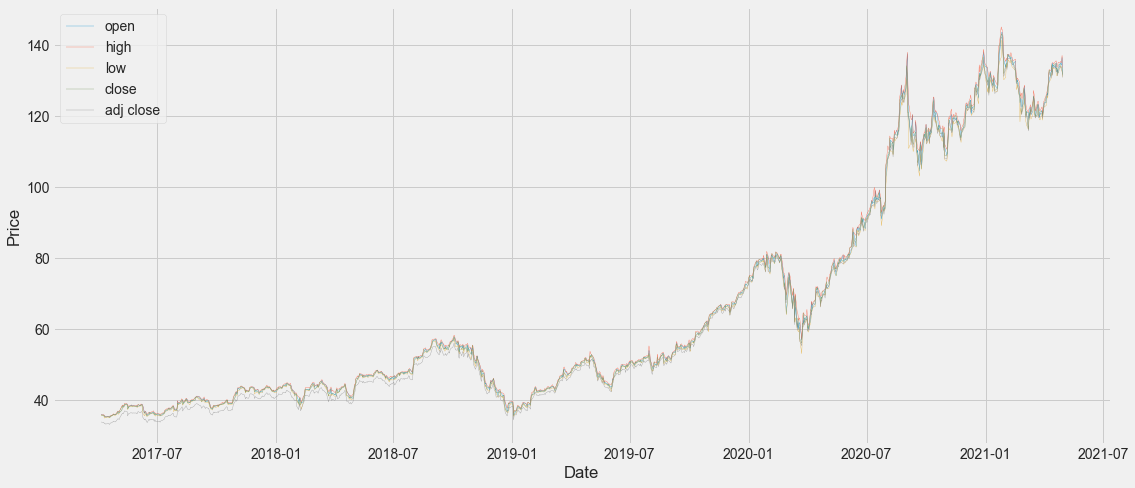

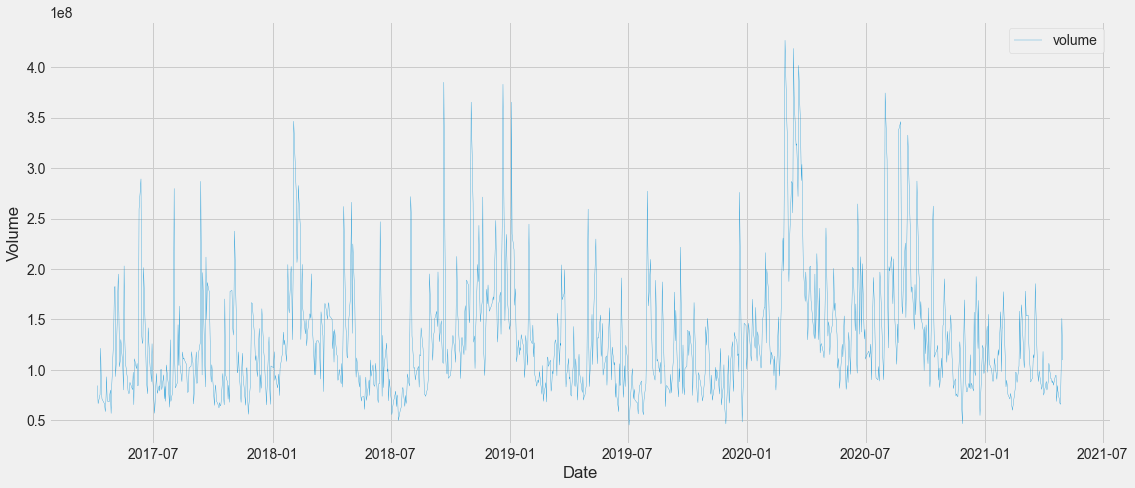

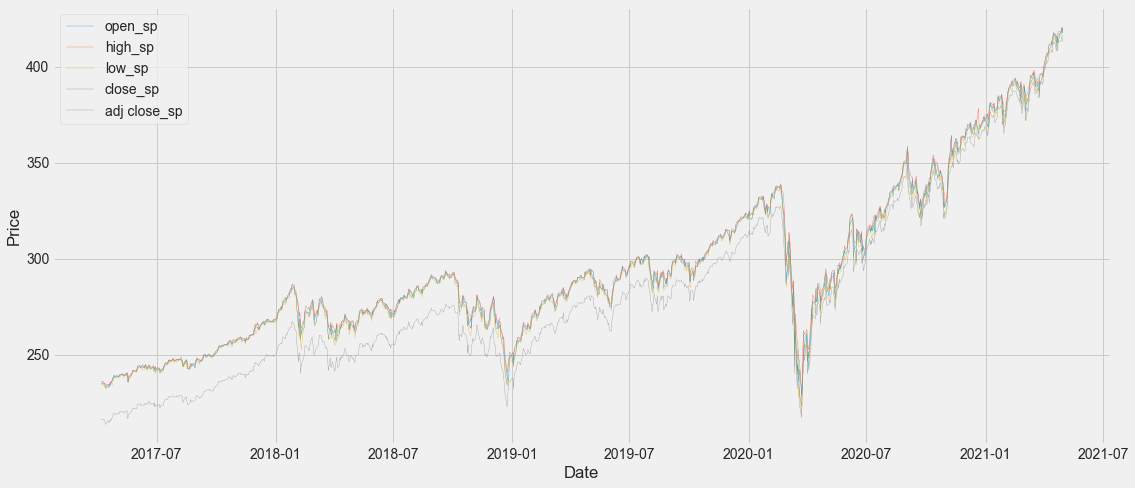

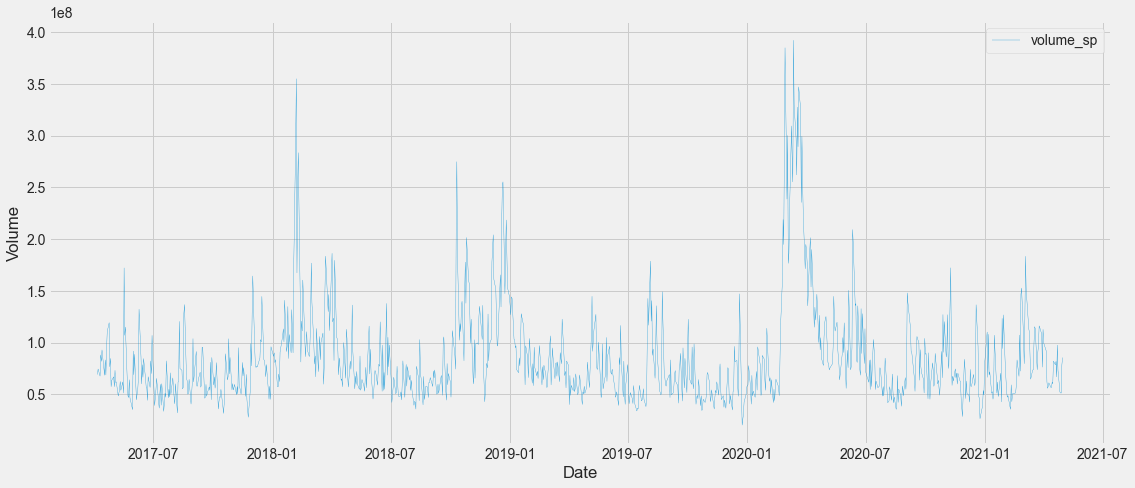

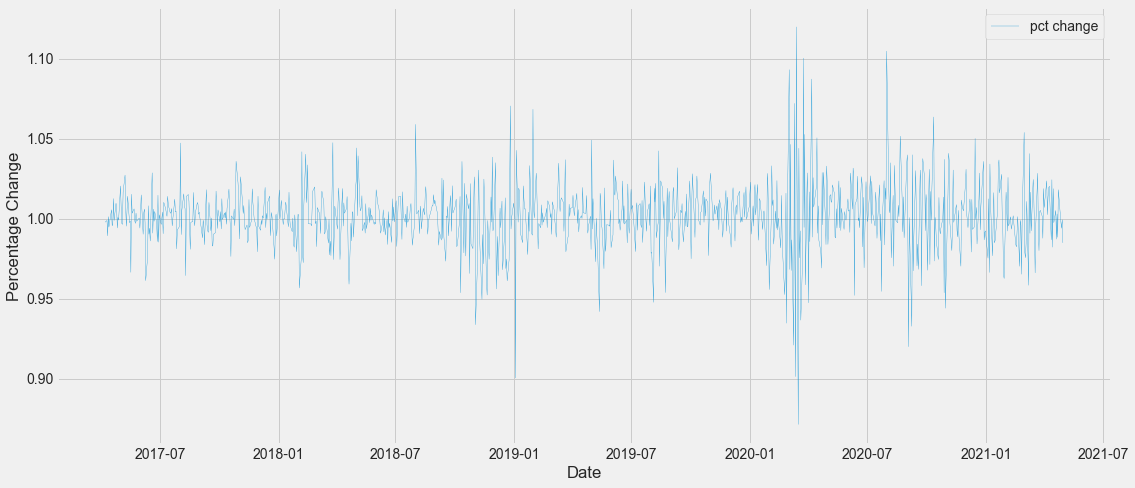

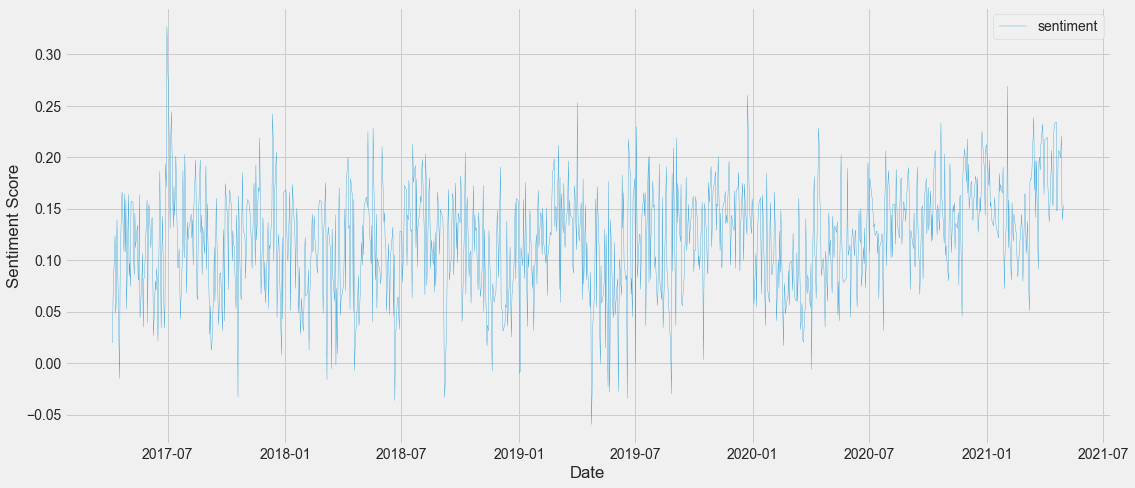

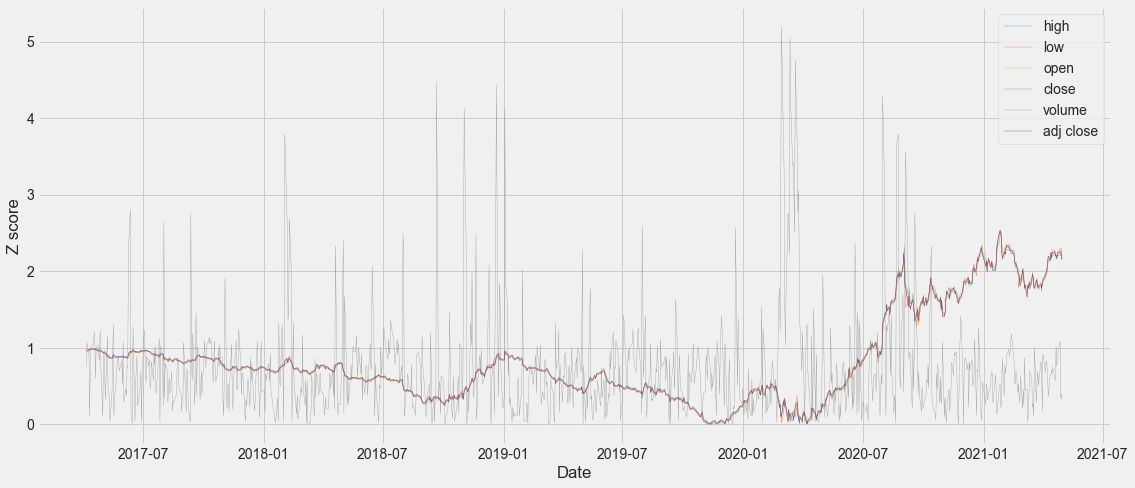

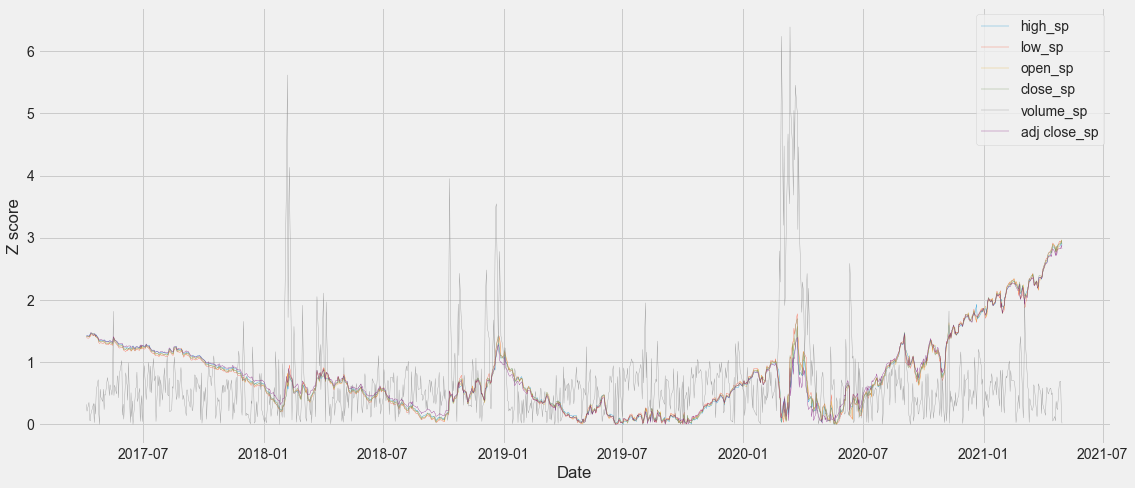

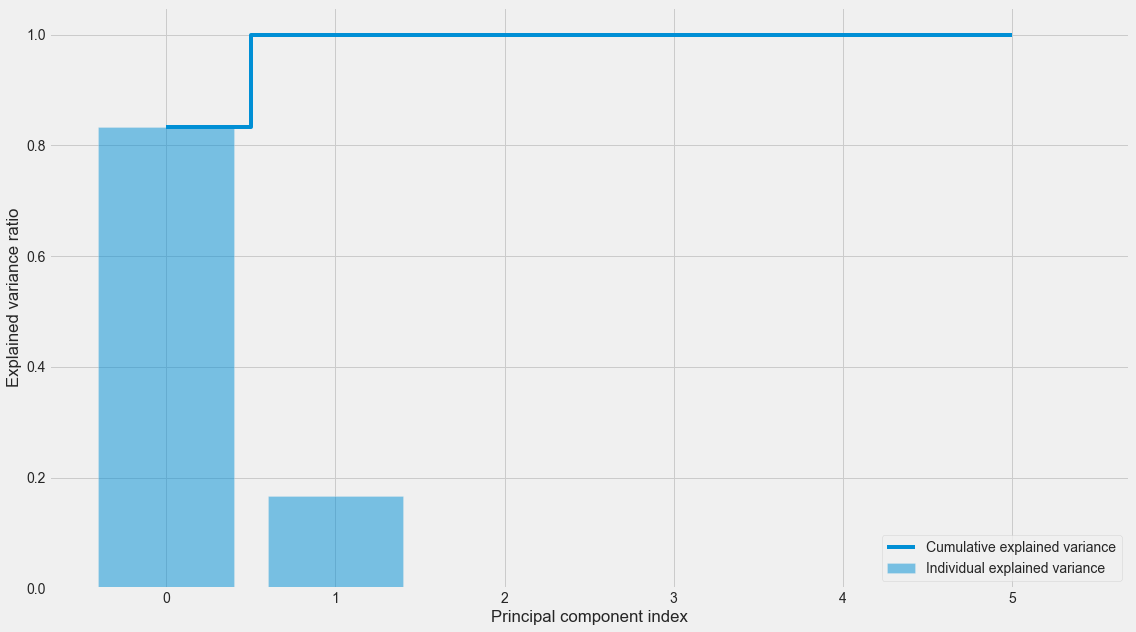

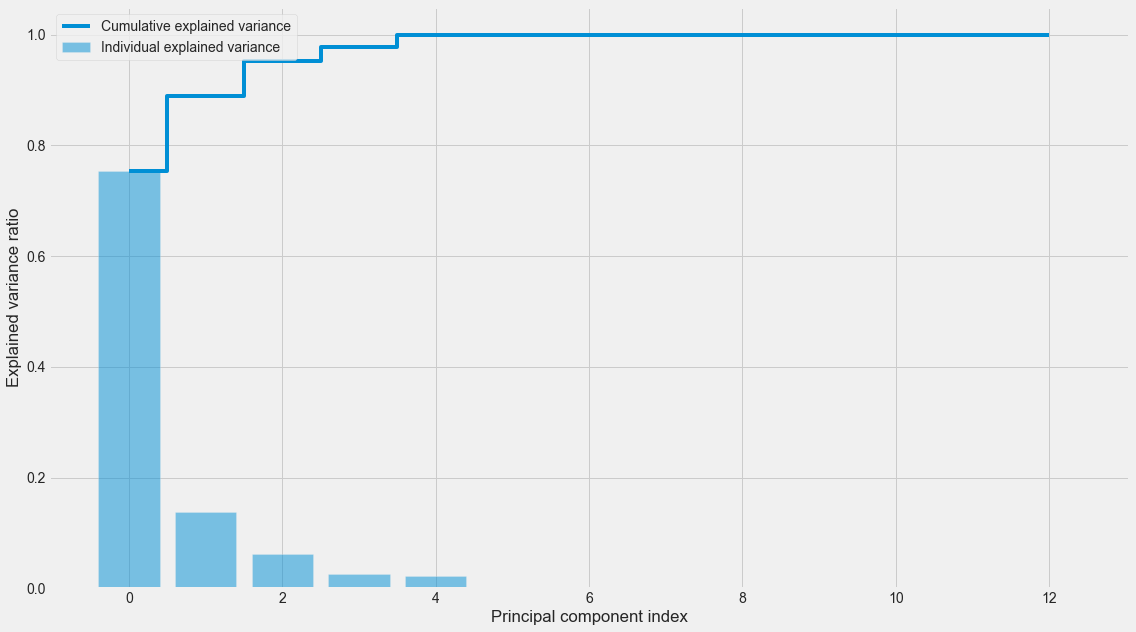

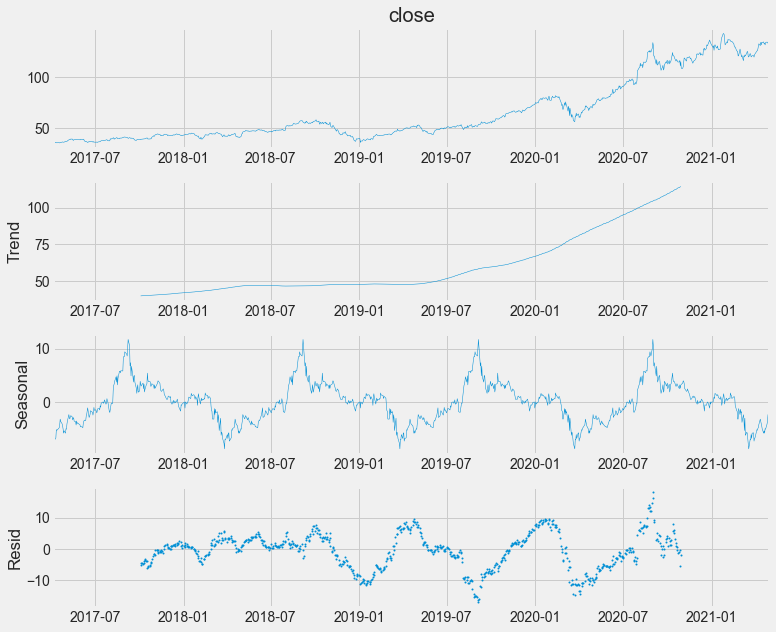

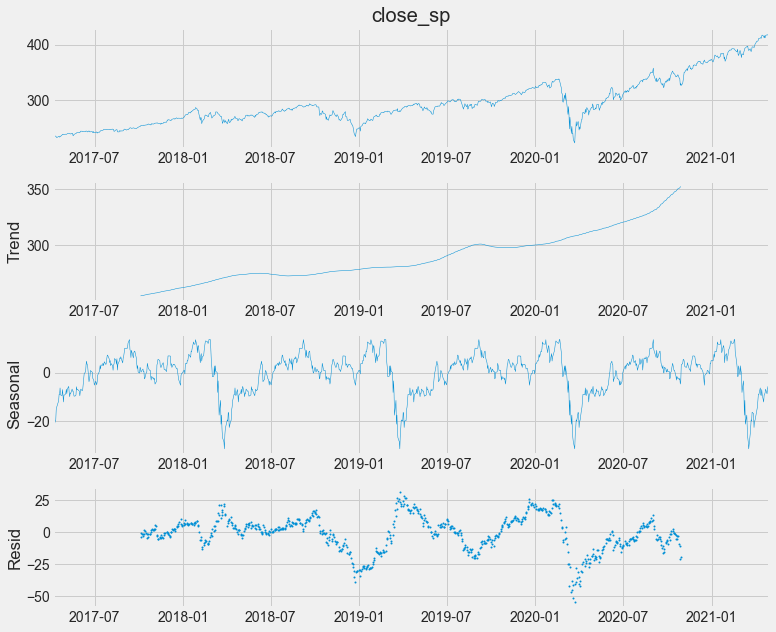

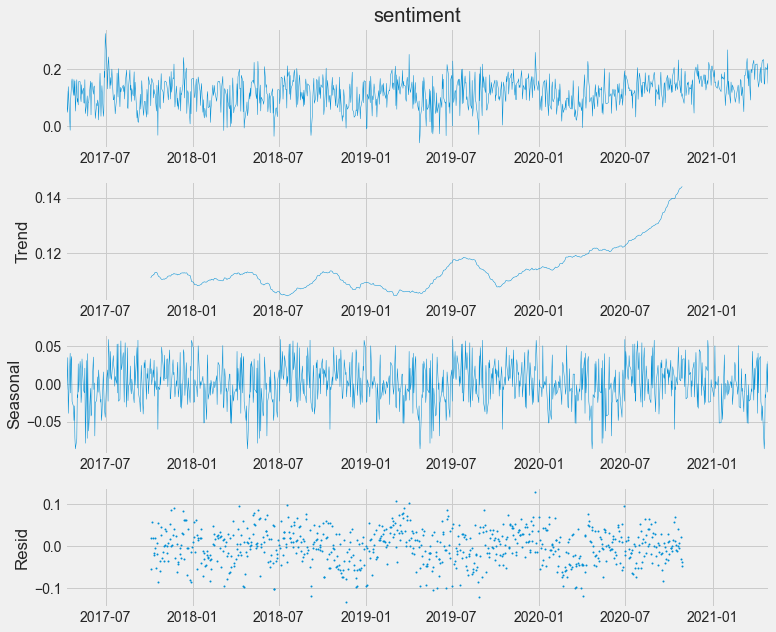

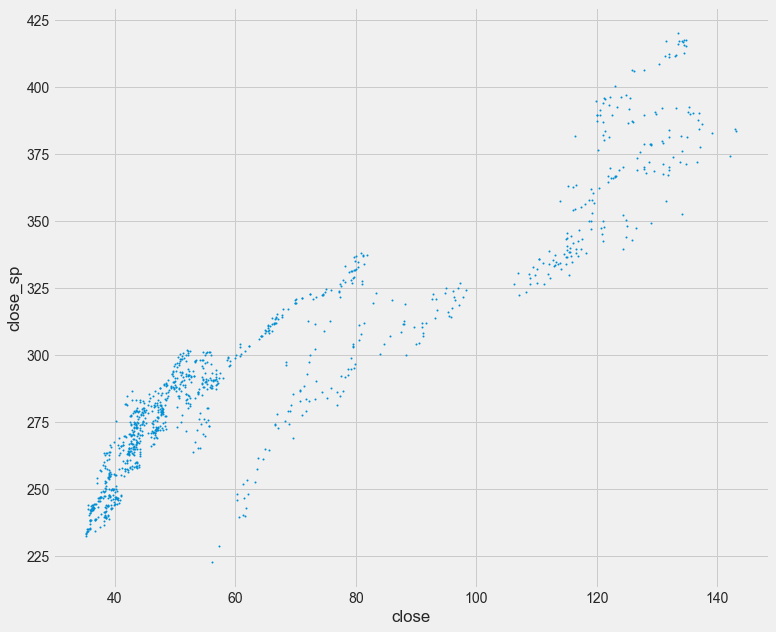

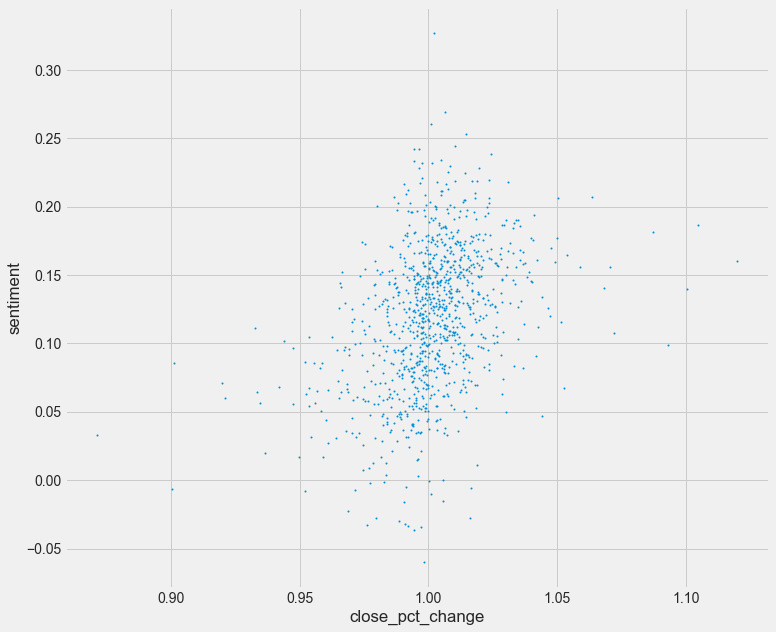

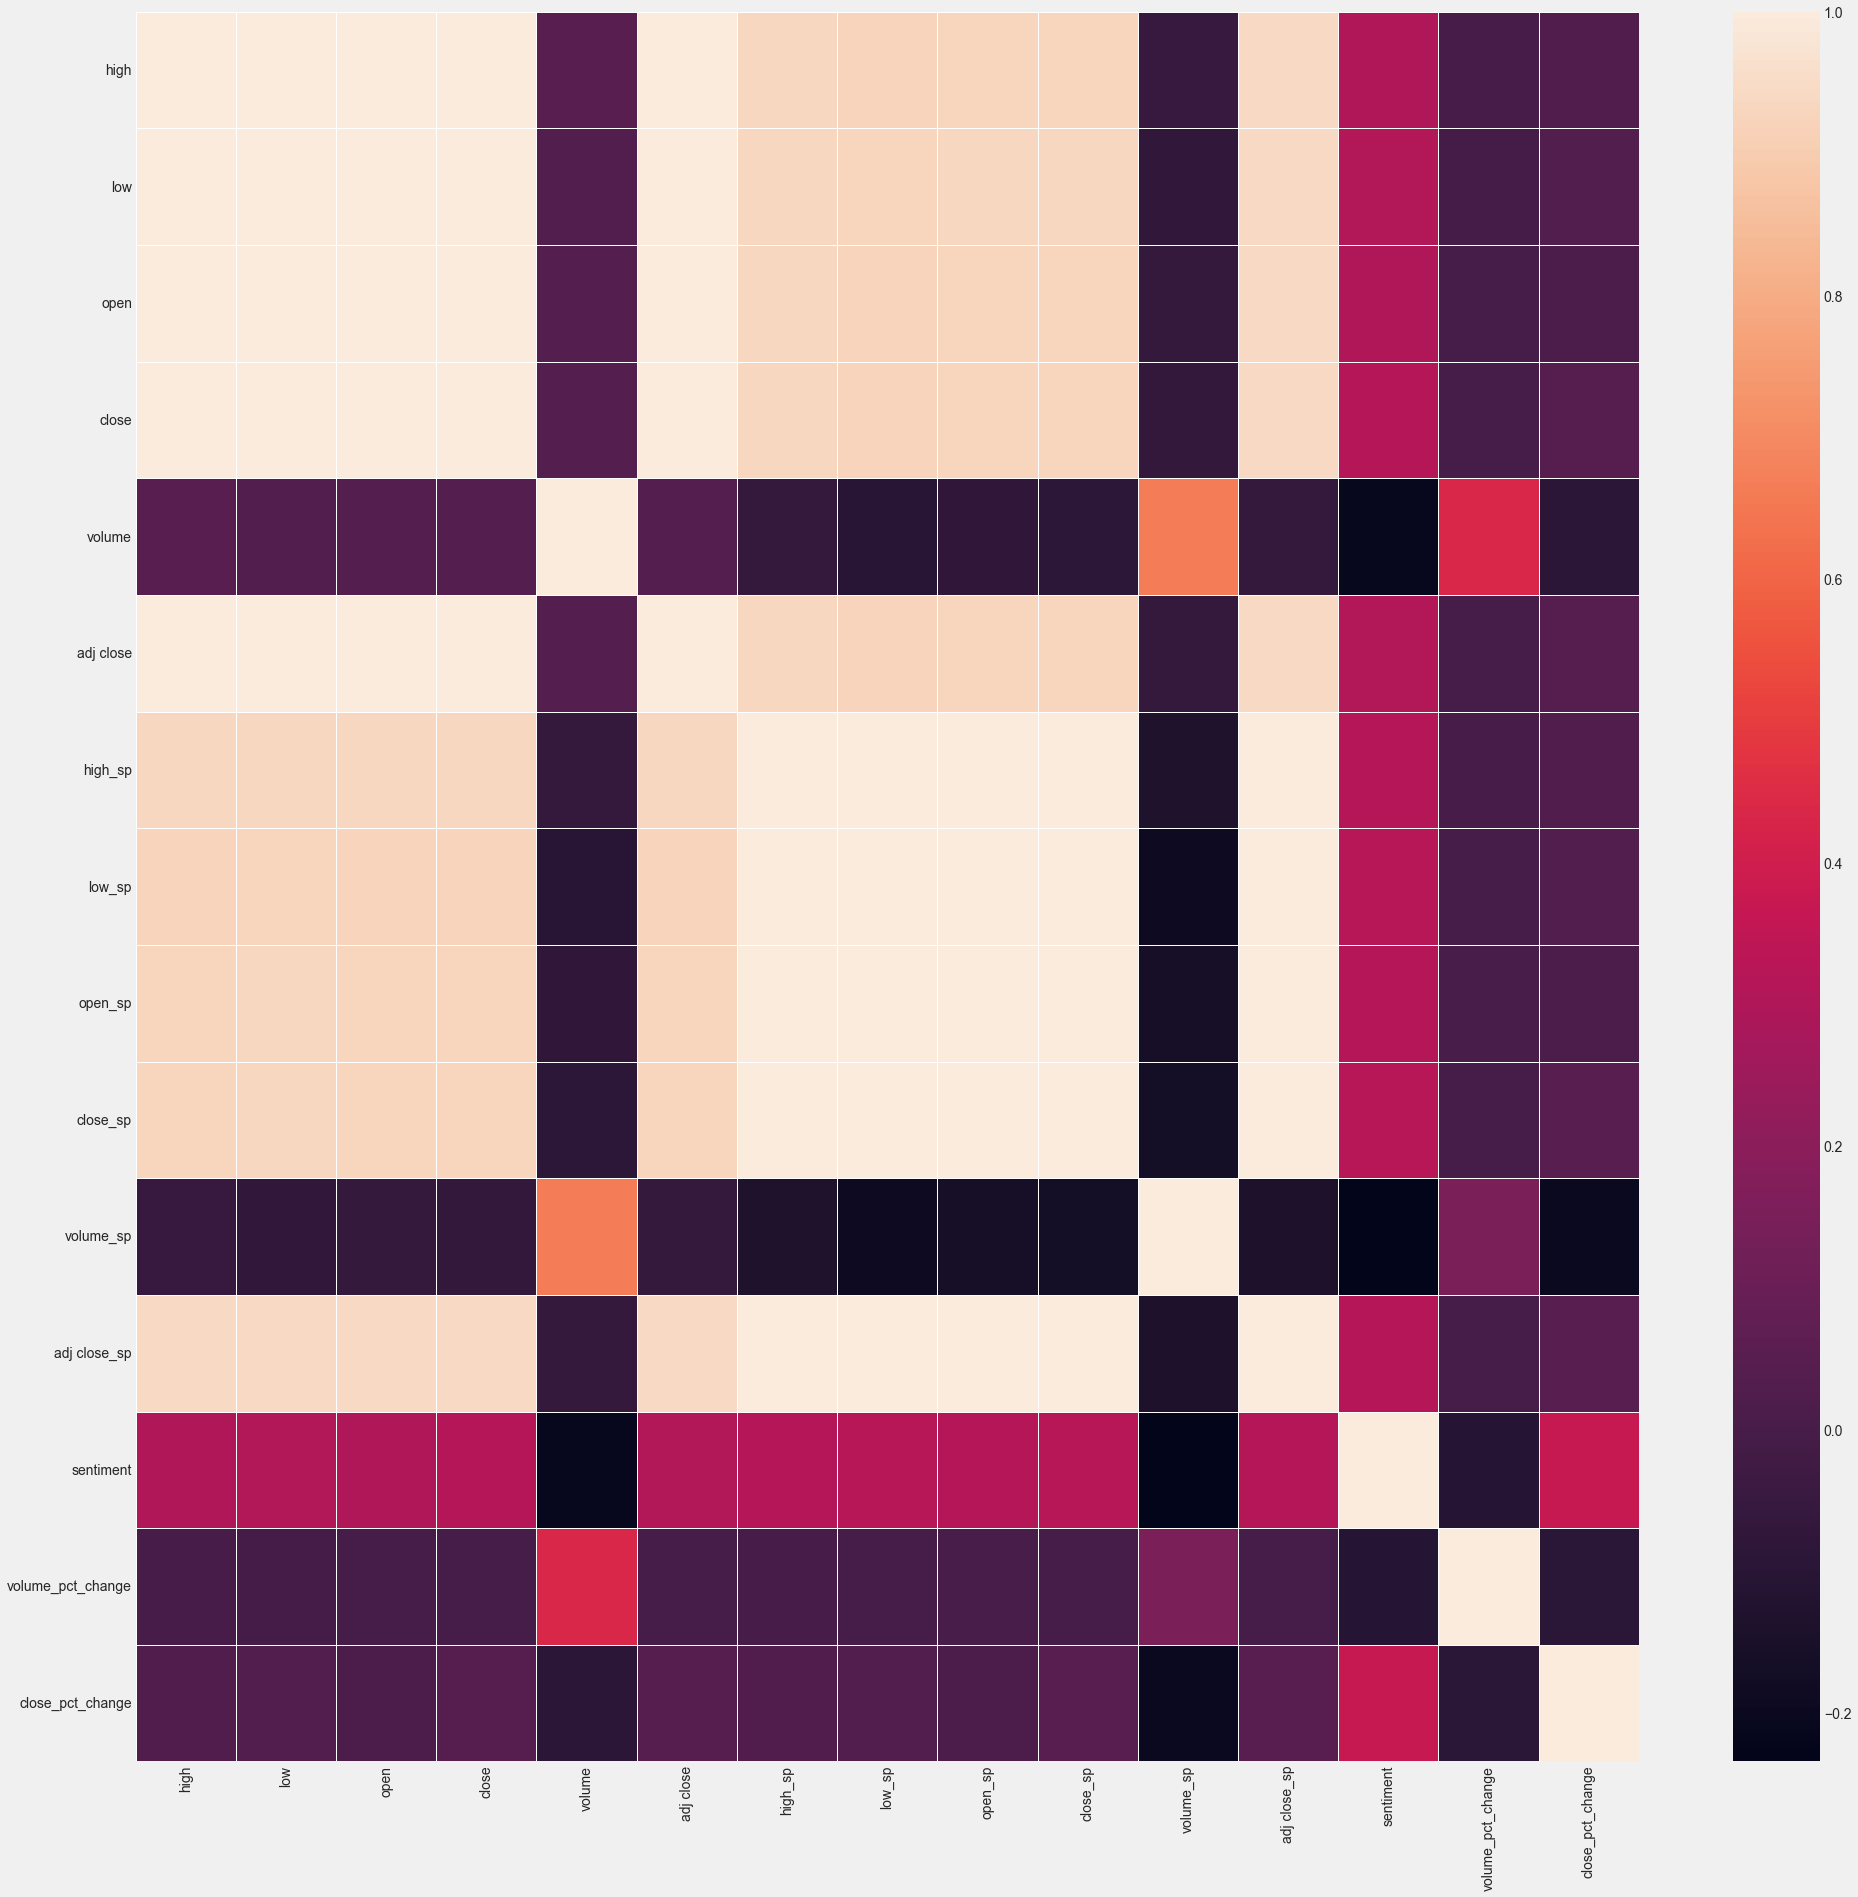

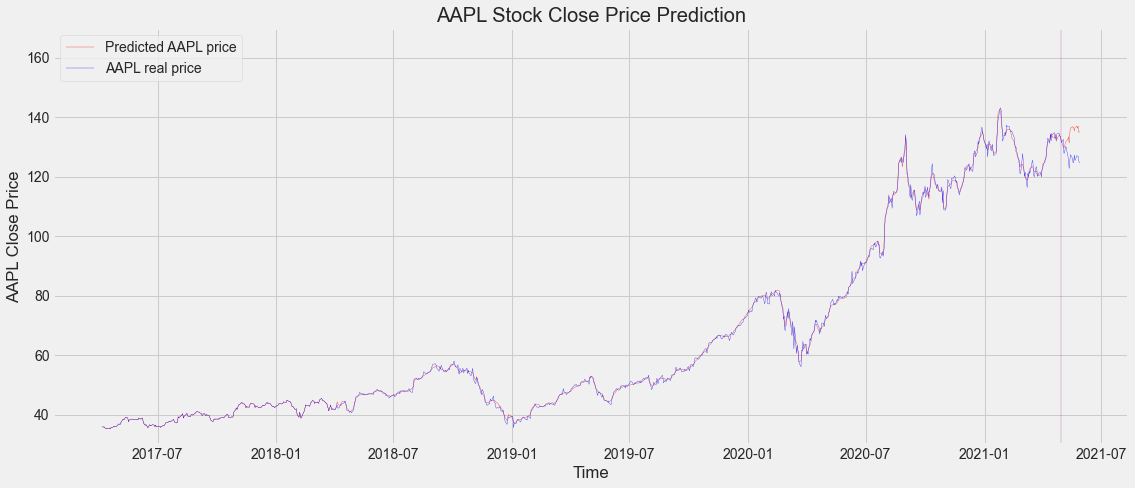

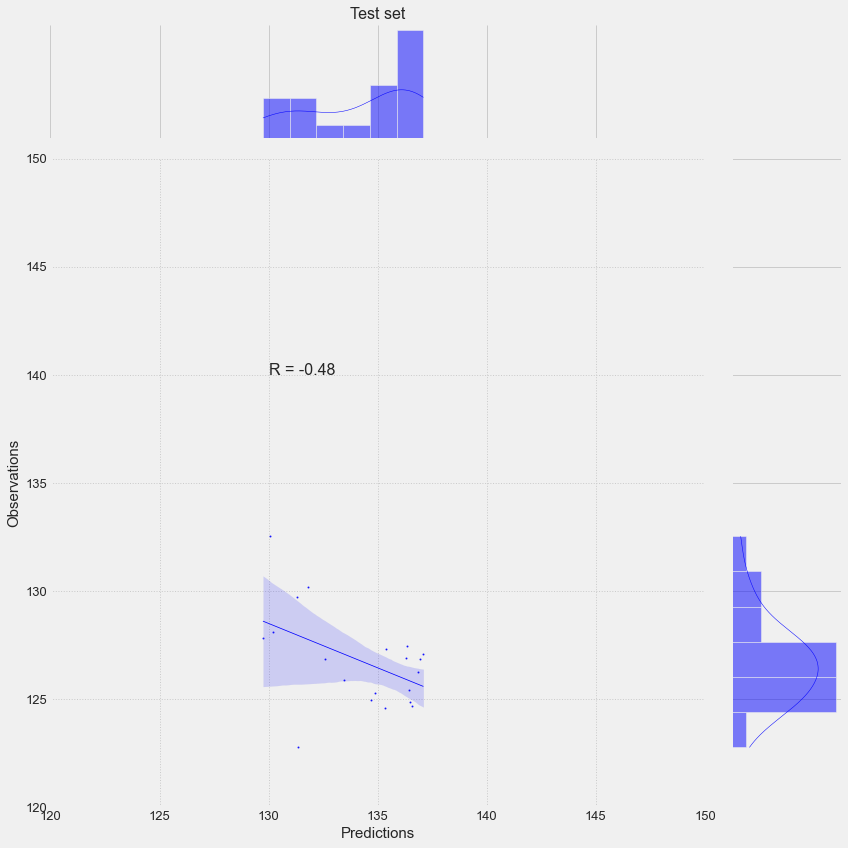

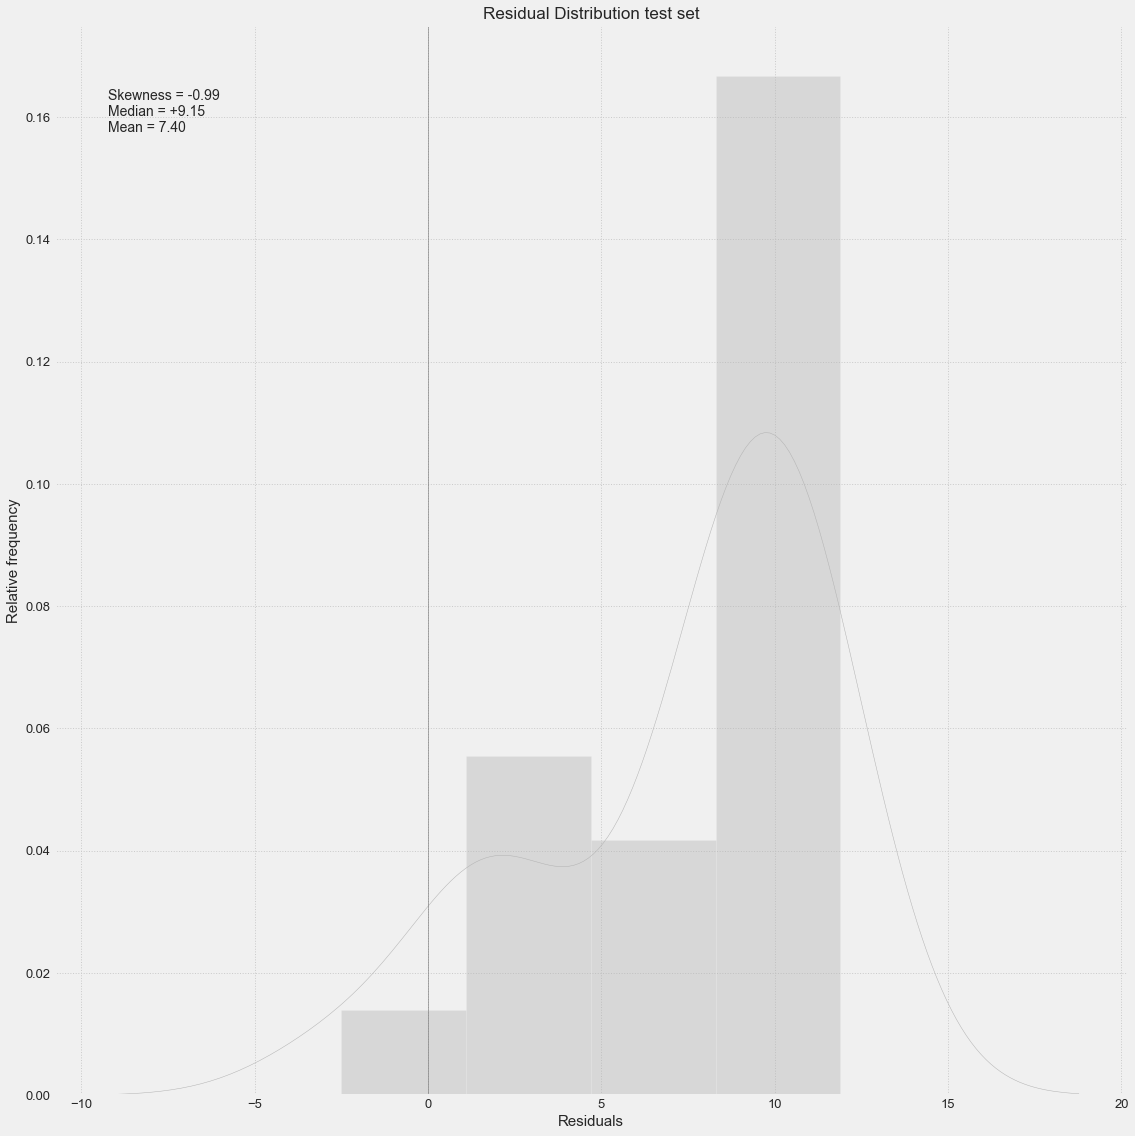

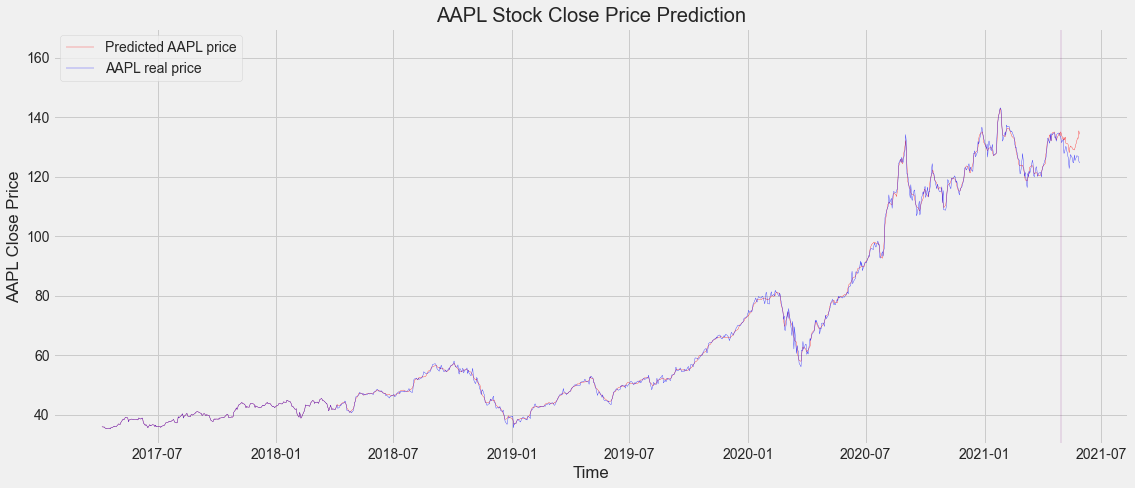

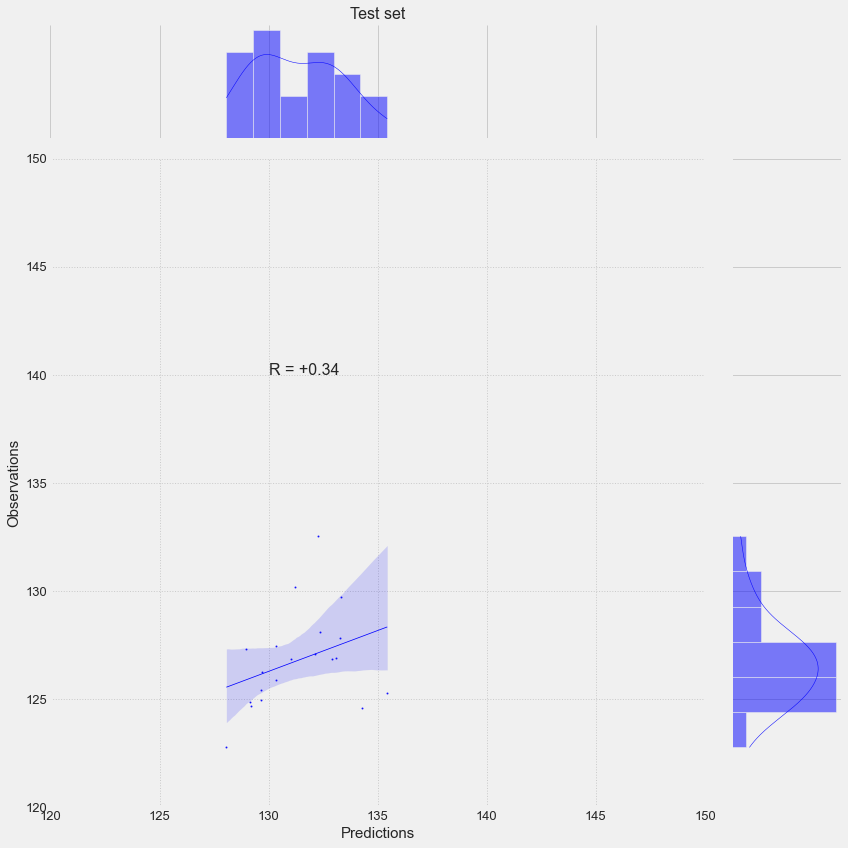

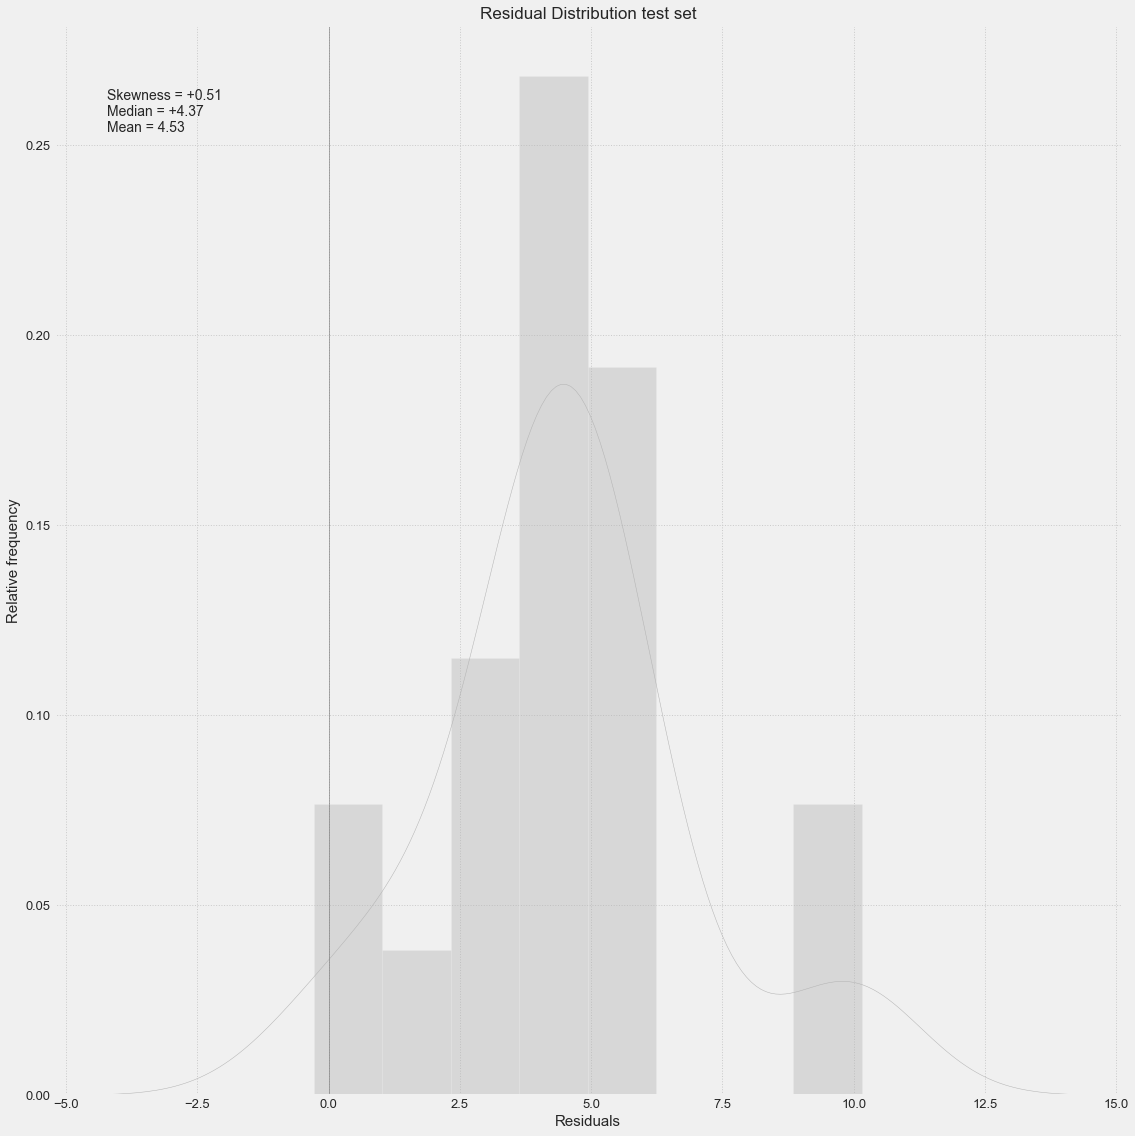

In [180]:
main()